In [17]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [18]:
from fastbook import *
from fastai.vision.widgets import *

In [19]:
key = os.environ.get('AZURE_SEARCH_KEY', '0269a202ba68419e963fced4a3553e0c')

FileExistsError: [Errno 17] File exists: 'images'

In [21]:
# Using the Bing Image Search API to for grizzly bear images and stores as fastcore's L (similiar to NumPy array)
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)

150

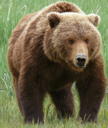

In [22]:
# Testing to see if images can be downloaded and displayed
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

im = Image.open(dest)
im.to_thumb(128, 128)

In [23]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [24]:
# Create a folder for the different bear types
if not path.exists():
    path.mkdir()

for o in bear_types:
  dest = (path/o)
  dest.mkdir(exist_ok=True)
  results = search_images_bing(key, f'{o} bear')
  download_images(dest, urls=results.attrgot('content_url'))
        

In [25]:
# Check to see there are different folders for each bear type
path.ls()

(#3) [Path('bears/grizzly'),Path('bears/black'),Path('bears/teddy')]

In [26]:
# Checking to see if the images were downloaded to one of the three folders
fns = get_image_files(path)
fns

(#464) [Path('bears/grizzly/00000001.jpg'),Path('bears/grizzly/00000006.jpg'),Path('bears/grizzly/00000008.jpg'),Path('bears/grizzly/00000009.jpg'),Path('bears/grizzly/00000010.jpg'),Path('bears/grizzly/00000005.jpg'),Path('bears/grizzly/00000002.jpg'),Path('bears/grizzly/00000007.jpg'),Path('bears/grizzly/00000003.jpg'),Path('bears/grizzly/00000004.jpg')...]

In [27]:
# Checking to see if any of the files corrupted or weren't images
failed = verify_images(fns)
failed

(#15) [Path('bears/grizzly/00000071.jpg'),Path('bears/black/00000023.jpg'),Path('bears/black/00000020.jpg'),Path('bears/black/00000047.jpg'),Path('bears/black/00000077.jpg'),Path('bears/black/00000144.jpg'),Path('bears/teddy/00000006.jpg'),Path('bears/teddy/00000089.jpg'),Path('bears/teddy/00000095.jpg'),Path('bears/teddy/00000119.jpg')...]

In [28]:
# Removing corrupted and non-images
failed.map(Path.unlink);

In [29]:
# Creating a DataBlock for the dataset which is like a template for creating a DataLoaders
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [30]:
# Telling fastai where the actual source of our data is
dls = bears.dataloaders(path)

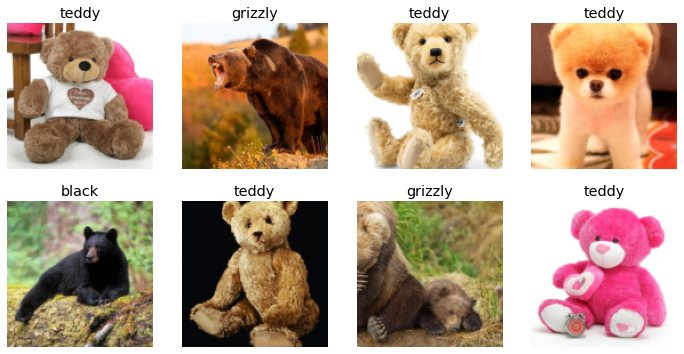

In [31]:
# Checking the images and their labels
dls.valid.show_batch(max_n=8, nrows=2)

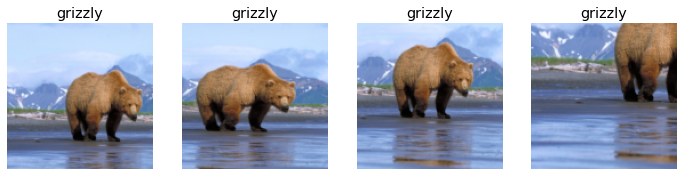

In [32]:
# Randomly select part of and image, and crop to just that part.
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True) #Using unique=True to have the same image repeated with different versions of RandomResizedCrop

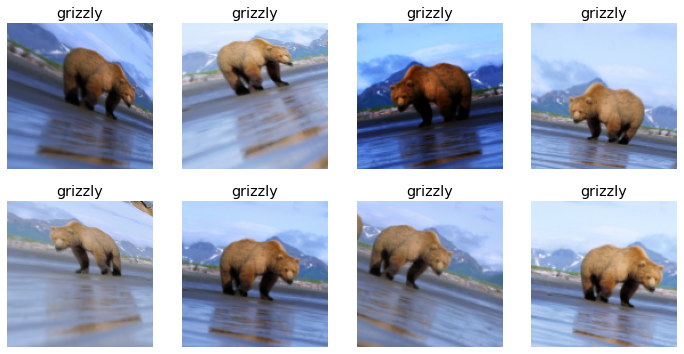

In [33]:
# Creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data.
# Data augmentation
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [34]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.811526,0.497596,0.168539,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.427348,0.235993,0.033708,00:09
1,0.332034,0.120204,0.011236,00:09
2,0.249289,0.108991,0.022472,00:09
3,0.203220,0.099370,0.011236,00:08
4,0.172823,0.094325,0.011236,00:09


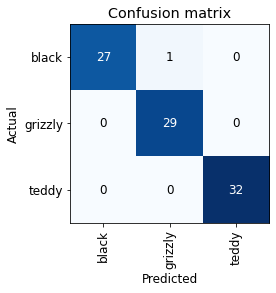

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

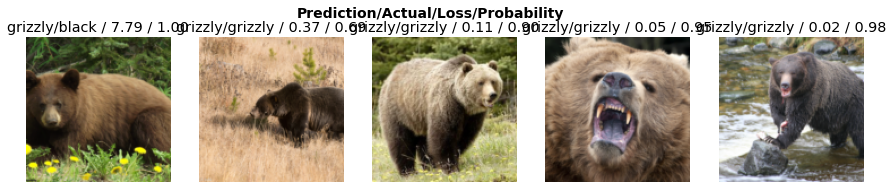

In [36]:
interp.plot_top_losses(5, nrows=1)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


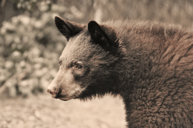

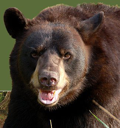

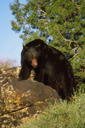

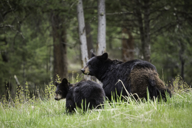

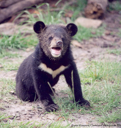

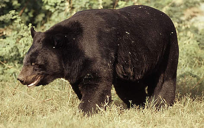

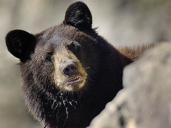

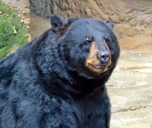

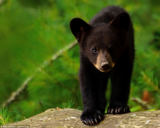

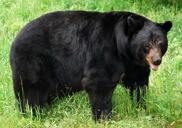

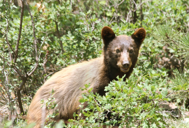

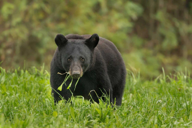

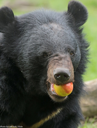

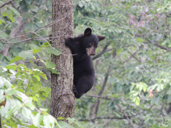

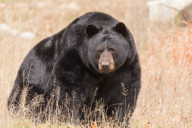

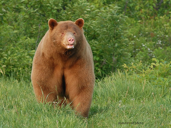

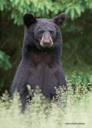

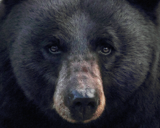

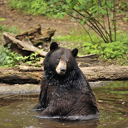

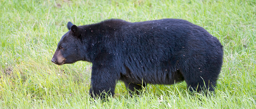

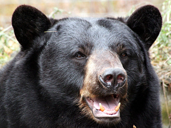

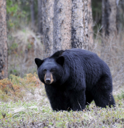

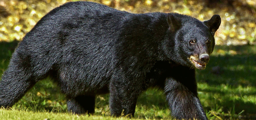

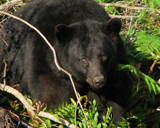

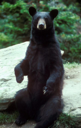

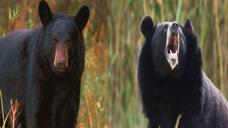

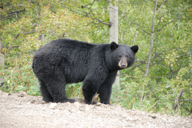

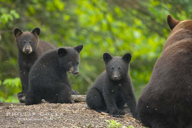

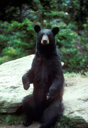

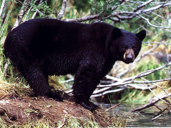

In [21]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [37]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

NameError: name 'cleaner' is not defined

In [38]:
learn.export()

In [39]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [40]:
learn_inf = load_learner(path/'export.pkl')

In [41]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([5.7389e-05, 9.9990e-01, 4.5961e-05]))

In [27]:
learn_inf.dls.vocab

(#3) ['black','grizzly','teddy']

In [42]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [43]:
img = PILImage.create(btn_upload.data[-1])

In [44]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [45]:
pred,pred_idx,probs = learn_inf.predict(img)

lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: black; Probability: 1.0000')

In [46]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [47]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [48]:
btn_upload = widgets.FileUpload()

In [49]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [52]:
!pip install voila --use-feature=2020-resolver
!jupyter serverextension enable --sys-prefix voila


Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.3 OK
